<!--NAVIGATION-->

<a target="_blank" href="https://colab.research.google.com/github/bpesquet/machine-learning-handbook/blob/master/notebooks/models/knn.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# K-Nearest Neighbors

## Package setup

In [1]:
# Import base packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'
sns.set()

In [3]:
# Import ML packages
import sklearn
print(f'scikit-learn version: {sklearn.__version__}')

from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix

scikit-learn version: 0.22.2.post1


## Utility functions

In [4]:
def plot_decision_boundary(pred_func, X, y, figure=None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)


## Planar data classification

x_train: (100, 2). y_train: (100,)


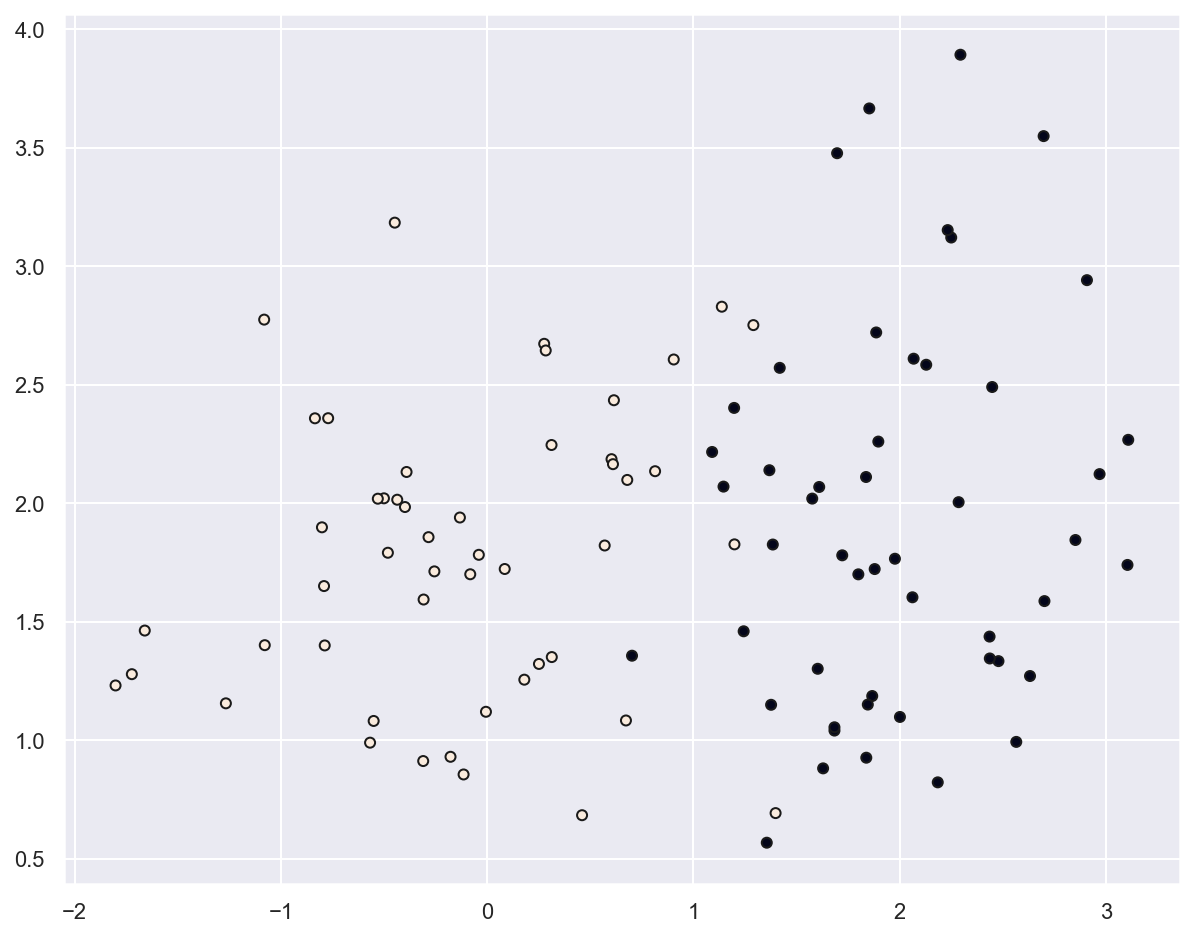

In [5]:
x_train, y_train = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)

rng = np.random.RandomState(2)
x_train += 2 * rng.uniform(size=x_train.shape)

plt.scatter(x_train[:, 0], x_train[:, 1], marker='o', c=y_train,
            s=25, edgecolor='k')

print(f'x_train: {x_train.shape}. y_train: {y_train.shape}')

In [6]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

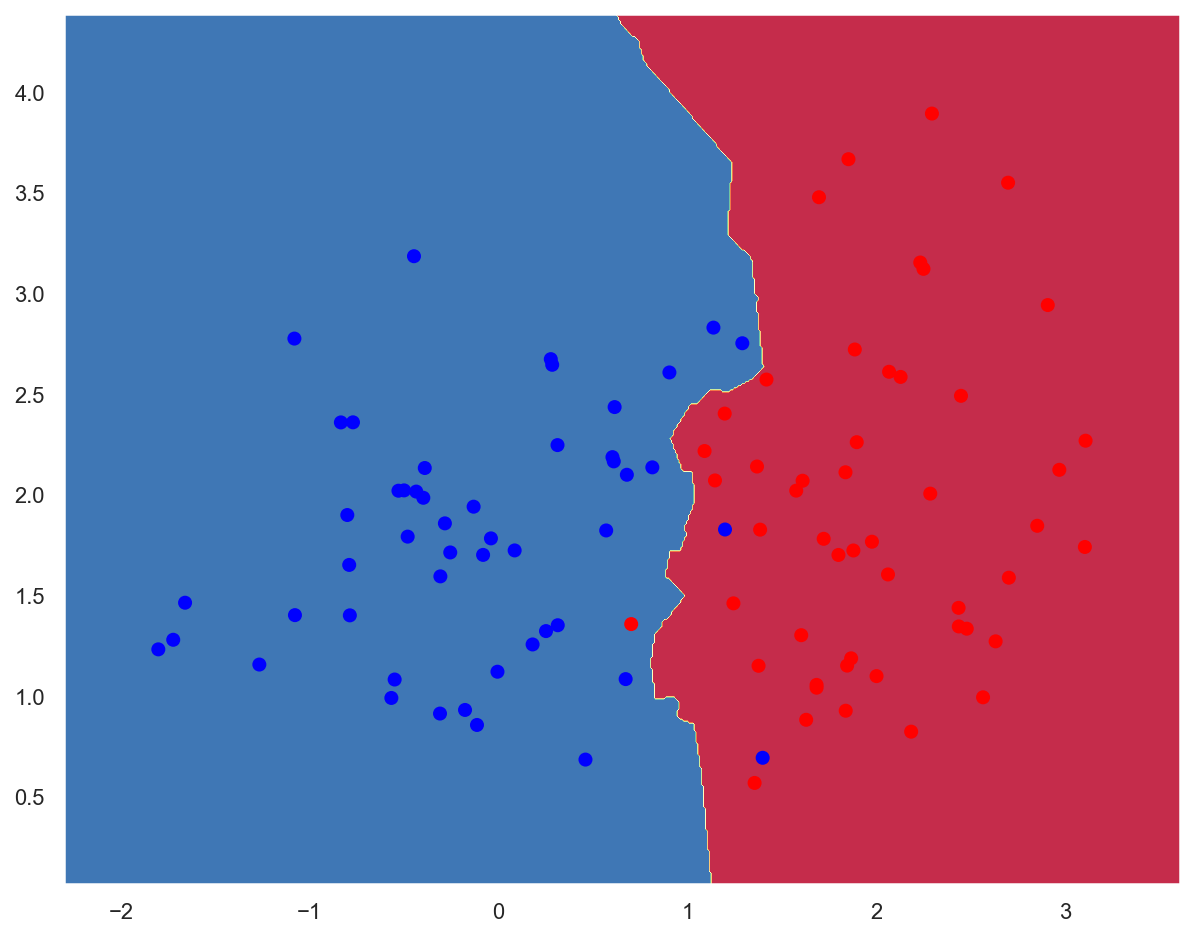

In [7]:
plot_decision_boundary(lambda x: model.predict(x), x_train, y_train)

In [8]:
train_acc = model.score(x_train, y_train)

print(f'Training accuracy: {train_acc * 100:.2f}%')

Training accuracy: 97.00%


## Fruits classification

### Step 1: Loading the data

In [9]:
!wget http://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt -O fruit_data_with_colors.txt

--2020-04-28 12:23:14--  http://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt
Résolution de www.eyrignoux.com.fr (www.eyrignoux.com.fr)… 62.210.16.62
Connexion à www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:80… connecté.
requête HTTP transmise, en attente de la réponse… 301 Moved Permanently
Emplacement : https://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt [suivant]
--2020-04-28 12:23:14--  https://www.eyrignoux.com.fr/coursIA/machineLearning/fruit_data_with_colors.txt
Connexion à www.eyrignoux.com.fr (www.eyrignoux.com.fr)|62.210.16.62|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 2370 (2,3K) [text/plain]
Sauvegarde en : « fruit_data_with_colors.txt »

fruit_data_with_col 100%[===================>]   2,31K  --.-KB/s    in 0s      

2020-04-28 12:23:15 (133 MB/s) — « fruit_data_with_colors.txt » sauvegardé [2370/2370]



In [10]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits.sample(n=10)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
13,1,apple,golden_delicious,164,7.3,7.7,0.70
31,3,orange,selected_seconds,210,7.8,8.0,0.82
20,1,apple,cripps_pink,160,7.5,7.5,0.86
39,3,orange,turkey_navel,144,6.8,7.4,0.75
45,4,lemon,spanish_belsan,186,7.2,9.2,0.72
15,1,apple,golden_delicious,156,7.7,7.1,0.69
40,3,orange,turkey_navel,154,7.1,7.5,0.78
1,1,apple,granny_smith,180,8.0,6.8,0.59
49,4,lemon,unknown,132,5.8,8.7,0.73
36,3,orange,turkey_navel,160,7.1,7.6,0.76


### Step 2: Preparing the data

In [11]:
# Evaluate class distribution
samples_count = fruits.size
for name in fruits['fruit_name'].unique():
    class_percent = fruits[fruits.fruit_name == name].size / samples_count
    print(f'{name}s : {class_percent * 100:.1f}%')

apples : 32.2%
mandarins : 8.5%
oranges : 32.2%
lemons : 27.1%


In [12]:
# For this example, we use the mass, width, and height features of each fruit instance
x = fruits[['mass', 'width', 'height']]
y = fruits['fruit_label']

print(f'x: {x.shape}. y: {y.shape}')

x: (59, 3). y: (59,)


In [13]:
# Split data between training and test sets with a 80/20 ratio
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

print(f'x_train: {x_train.shape}. y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}. y_test: {y_test.shape}')

x_train: (47, 3). y_train: (47,)
x_test: (12, 3). y_test: (12,)


In [14]:
# Standardize data
scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### Step 3: Creating a classifier

In [15]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Step 4: Evaluating the classifier

In [16]:
# Compute accuracy on training and test sets
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)

print(f'Training accuracy: {train_acc * 100:.2f}%')
print(f'Test accuracy: {test_acc * 100:.2f}%')

Training accuracy: 91.49%
Test accuracy: 75.00%


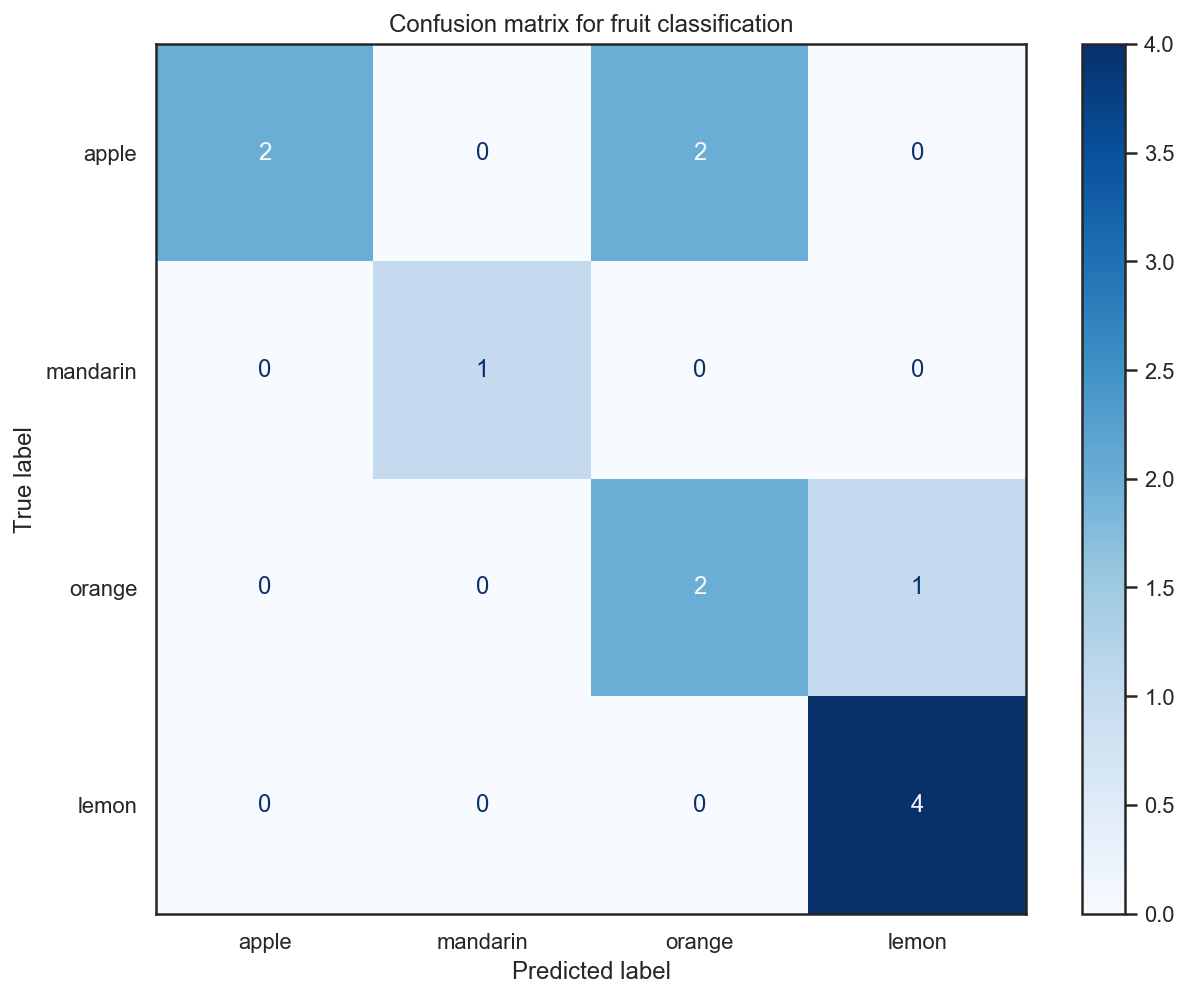

In [17]:
# Plot the confusion matrix
# plot_confusion_matrix() was introduced in scikit-learn 0.22
if sklearn.__version__ >= "0.22":
    # Temporary hide Seaborn grid lines
    with sns.axes_style('white'):
        display = plot_confusion_matrix(model, x_test, y_test, 
                                        display_labels=fruits['fruit_name'].unique(),
                                        cmap=plt.cm.Blues)
        display.ax_.set_title("Confusion matrix for fruit classification")
        plt.show()

### Step 5 - Using the classifier for predictions

In [18]:
# create a mapping from fruit label value to fruit name to make results easier to interpret
lookup_fruit_name = dict(zip(fruits.fruit_label.unique(), fruits.fruit_name.unique()))

In [19]:
# first example: a small fruit with mass 20g, width 4.3 cm, height 5.5 cm
fruit_prediction = model.predict([[20, 4.3, 5.5]])
lookup_fruit_name[fruit_prediction[0]]

'orange'

In [20]:
# second example: a larger, elongated fruit with mass 100g, width 6.3 cm, height 8.5 cm
fruit_prediction = model.predict([[100, 6.3, 8.5]])
lookup_fruit_name[fruit_prediction[0]]

'orange'

### Step 6: Tuning the classifier

#### Importance of the `k` parameter

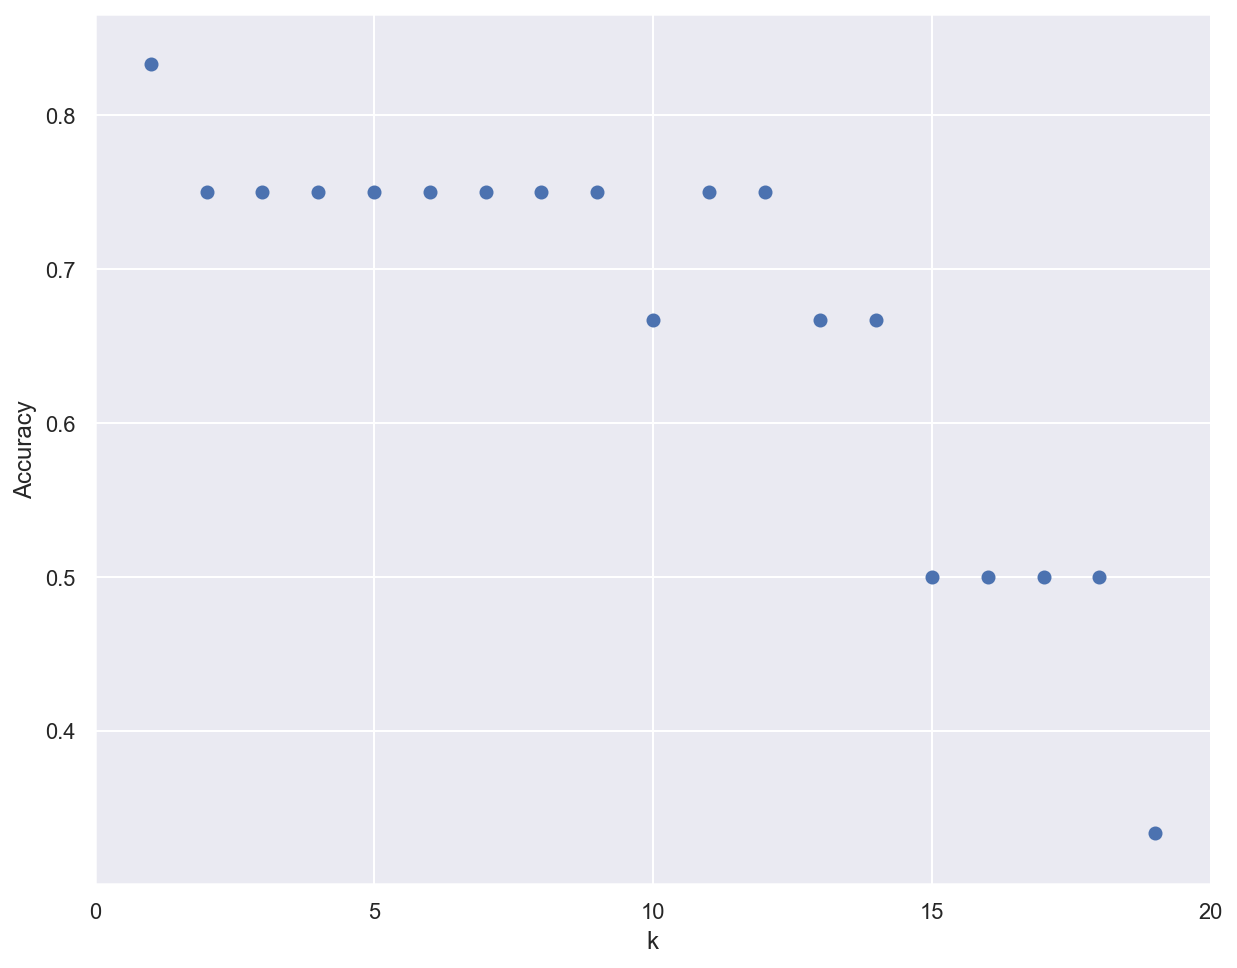

In [21]:
k_range = range(1,20)
scores = []

for k in k_range:
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(x_train, y_train)
    scores.append(model.score(x_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20]);

#### Importance of the training/test sets proportions

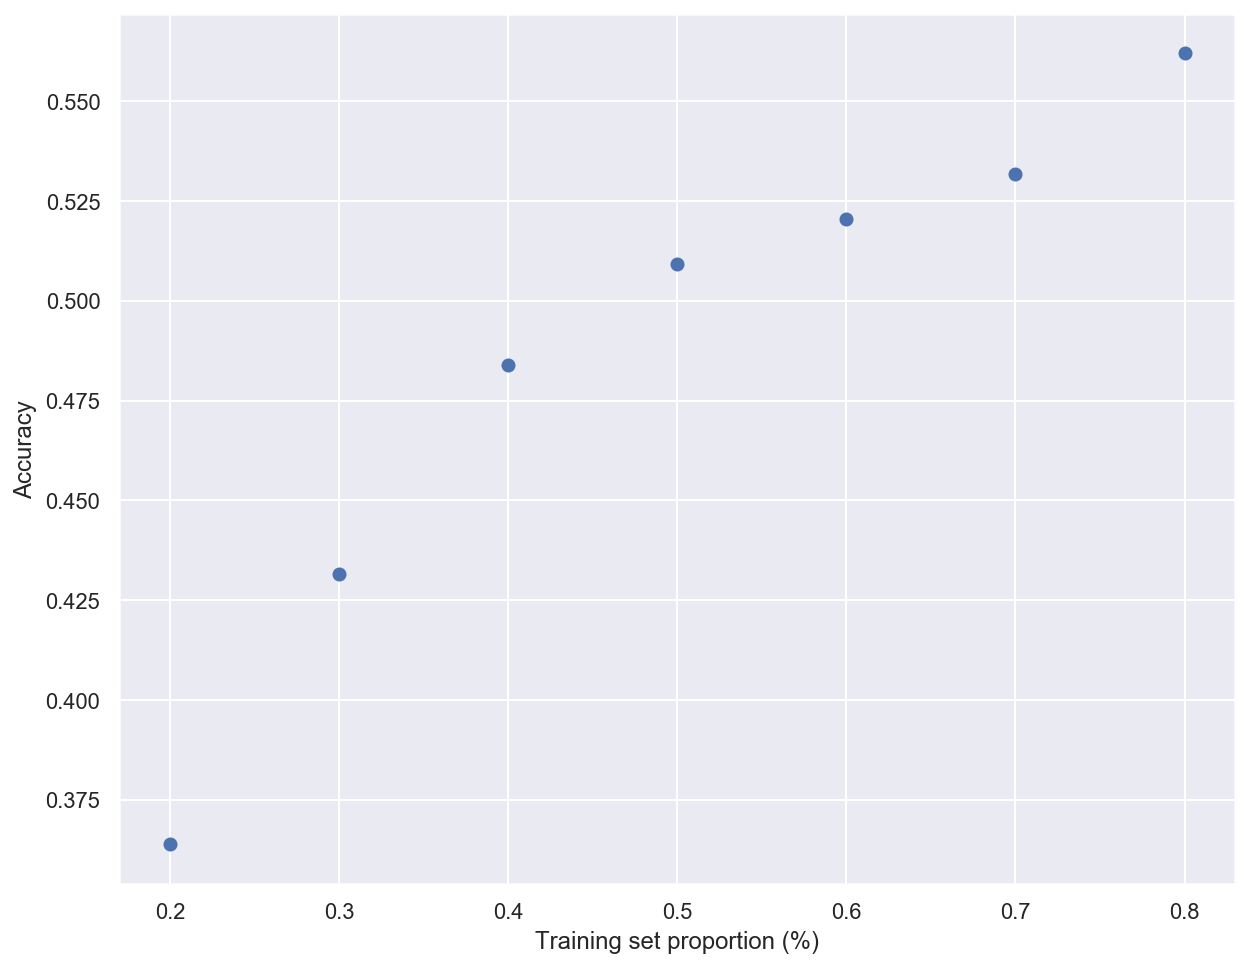

In [22]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

model = KNeighborsClassifier(n_neighbors = 5)

plt.figure()

for s in t:

    scores = []
    for i in range(1,1000):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1-s)
        model.fit(x_train, y_train)
        scores.append(model.score(x_test, y_test))
    plt.plot(s, np.mean(scores), 'bo')

plt.xlabel('Training set proportion (%)')
plt.ylabel('Accuracy');

## TODO

- Planar data: add multiclass data
- Better loking graphs: https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/